In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from plotnine import *
from sklearn.linear_model import LogisticRegression # Logistic Regression Model
from sklearn.linear_model import LinearRegression, Lasso # Logistic Regression Model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error #model evaluation
from pathlib import Path 


from sklearn.preprocessing import StandardScaler #Z-score variables
from sklearn.neighbors import KNeighborsClassifier

from sklearn.cluster import KMeans # k-means
from sklearn.mixture import GaussianMixture # EM/GMM
from sklearn.cluster import AgglomerativeClustering # hierarchical agglomerative clustering
from sklearn.model_selection import train_test_split # simple TT split cv
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.metrics import silhouette_score 
import scipy.cluster.hierarchy as sch
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture


%matplotlib inline

Data Set Overview:

The data we are analyzing comes from a Garmin smartwatch collected by Michael's friends parent (who we will call Dan). These watches track a variety of metrics such as heart rate, stress and various others. This allows for the user to adjust their workouts in order to reach certain goals based upon their own personal metrics. For this specific dataset we are looking at running workouts that span from the past year starting 11/19/19 up to 11/24/20, some of these dates contain more than one observation, meaning Dan worked out more than one time that day. The following are the variables that accompany the dataset, I will provide a brief description of each one:


- Activity Type: The type of workout that occured 
- Date: The time and date the workout took place
- Favorite: Whether or not the location is a preferred place for the user
- Title: Location of workout
- Distance: Distance covered in miles
- Calories: Calories burned
- Time: How long the workout lasted
- Avg HR: Average heart rate
- Max HR: Maximum Heartrate
- Aerobic TE: Aerobic Training Effect is the excess post-exercise oxygen consumption (EPOC) accumulated during exercise
- Avg Run Cadence: Average number of steps you take per minute
- Max Run Cadence: Maximum number of steps you take per minute
- Avg Pace: Average pace during the run
- Best Pace: Best pace during the run
- Elev Gain: The total amount of ascent that was recorded for an activity in feet
- Elev Loss: The total amount of descent that was recorded for an activity in feet
- Avg Stride Length: Average distance traveled during that motion
- Avg Vertical Ratio: Vertical Oscillation divided by your Stride Length
- Avg Vertical Oscillation: Average amount that the torso moves vertically with each step while running
- Training Stress Score®: A way of measuring how much stress is put on the body from a ride
- Grit: *Used for cycling*
- Flow: *Used for cycling*
- Climb Time: Time spent elevating
- Bottom Time: *Used for diving*
- Min Temp: Minimum temprature recorded in Fahrenheit
- Surface Interval: *Used for diving*
- Decompression: *Used for diving*
- Best Lap Time: Fastet lap recorded
- Number of Laps: Number of laps that occured
- Max Temp: Highest temperature recorded in Fahrenheit
- Avg Resp: Average respiration rate that occured during the workout
- Min Resp: Minimum respiration rate that occured during the workout
- Max Resp: Maximum respirtation rate that occured during the workout

Below is a glimpse of the dataset as a whole before cleaning:

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/michaelkulinich/garmin_datascience_project/main/Activities-2.csv")
df.head()

,Activity Type,Date,Favorite,Title,Distance,Calories,Time,Avg HR,Max HR,Aerobic TE,...,Grit,Flow,Climb Time,Bottom Time,Min Temp,Surface Interval,Decompression,Best Lap Time,Number of Laps,Max Temp
0,Running,2020-11-24 07:07:08,False,San Jose ML13,13.00,"1,092",02:01:20,138,165,2.9,...,0.0,0.0,2:01:20,0:00,53.6,0:00,No,00:01.71,14,0.0
1,Running,2020-11-23 07:02:22,False,San Jose ML12,12.11,887,01:56:26,127,148,2.5,...,0.0,0.0,1:56:26,0:00,59.0,0:00,No,00:56.72,13,0.0
2,Running,2020-11-22 07:10:09,False,Hills 14,14.50,"1,319",02:26:28,137,158,3.1,...,0.0,0.0,2:26:28,0:00,55.4,0:00,No,04:36.41,15,0.0
3,Running,2020-11-21 07:07:08,False,Leland ML12,12.20,957,01:36:20,142,161,2.9,...,0.0,0.0,1:36:20,0:00,53.6,0:00,No,01:53.10,13,0.0
4,Running,2020-11-20 06:47:05,False,San Jose ML11,11.20,998,01:42:21,138,166,3.1,...,0.0,0.0,1:42:21,0:00,51.8,0:00,No,01:52.99,12,0.0


Up next are some visualizations of some of the more important variables for measuring workout success:

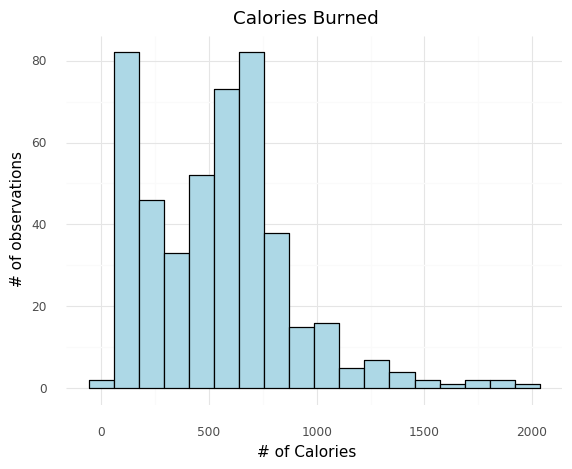

<ggplot: (8782358977865)>

In [64]:
#calories histogram
(ggplot(df, aes("Calories")) + 
 geom_histogram(color="black",fill="lightblue")+
ggtitle("Calories Burned")+
xlab("# of Calories")+
ylab("# of observations")+
theme_minimal())

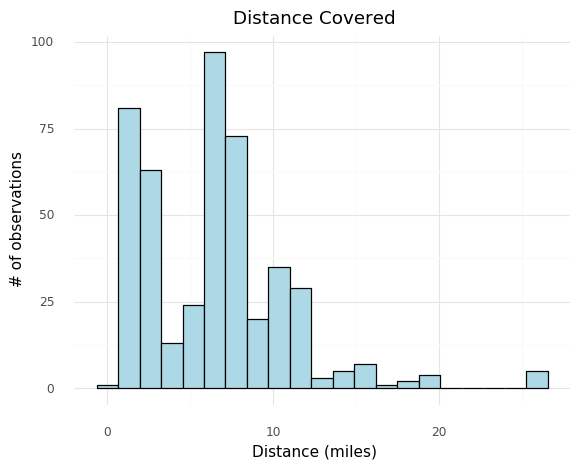

<ggplot: (8782352524269)>

In [65]:
#distance histogram
(ggplot(df, aes("Distance")) + 
 geom_histogram(color="black",fill="lightblue")+
ggtitle("Distance Covered")+
xlab("Distance (miles)")+
ylab("# of observations")+
theme_minimal())

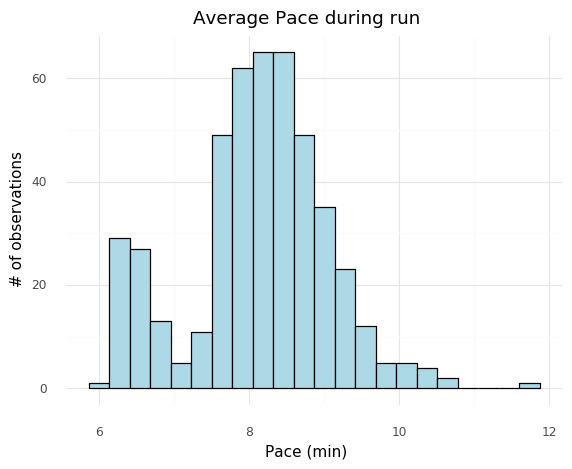

<ggplot: (8782352621533)>

In [66]:
#average pace histogram
(ggplot(df, aes("Avg Pace"))+
 geom_histogram(color="black",fill="lightblue")+
ggtitle("Average Pace during run")+
xlab("Pace (min)")+
ylab("# of observations")+
theme_minimal())

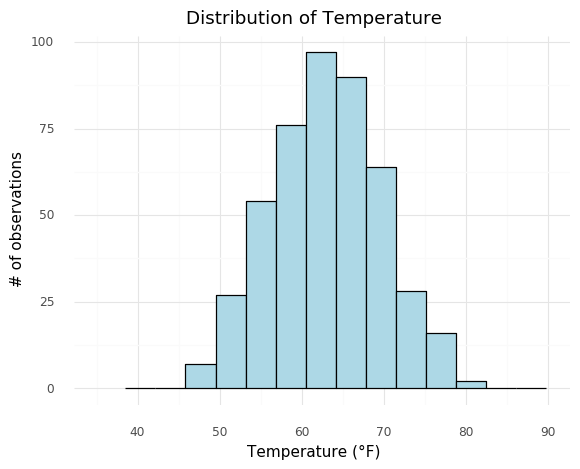

<ggplot: (8782358980809)>

In [67]:
#histogram for temperature
(ggplot(df, aes("Min Temp")) +
 geom_histogram(color="black",fill="lightblue")+
ggtitle("Distribution of Temperature")+
xlab("Temperature (°F)")+
ylab("# of observations")+
theme_minimal()+
xlim(35,90))

In [7]:
# convert the column of Time from "Hours:Minutes:Seconds" to "minutes" for each Time
def calc_time_minutes(times): # List of times
    conversion = [60, 1, 1/60]
    new_times = []
    for row in times:
        time_list = row.split(":")
        minutes = 0.

        # multiple the respective indeces "Hours:Minutes:Seconds" by specific
        # amount to convert to minutes
        for i, conv in zip(time_list, conversion): 
            minutes += float(i) * conv

        new_times.append(round(minutes, 3))
    return new_times

# convert the column of Avg pace from "Minutes:Seconds" to "Minutes" for each Avg Pace
def calc_avg_pace_minutes(times):
    conversion = [1, 1/60]
    new_times = []
    for row in times:
        time_list = row.split(":")
        minutes = 0.

        # multiple the respective indeces "Hours:Minutes:Seconds" by specific
        # amount to convert to minutes
        for i, conv in zip(time_list, conversion): 
            minutes += float(i) * conv
        new_times.append(round(minutes, 3))
    return new_times


# convert the column of calories for string values to int for each calorie
def calories_to_num(calories):
    return [int(calorie.replace(",", "")) for calorie in calories]

#convert column date to just the month
def change_date(dates):
    month_dict = {"01": "Jan", "02": "Feb", "03": "Mar", "04": "Apr", "05": "May", "06": "Jun", "07": "Jul", "08": "Aug", "09": "Sep", "10": "Oct", "11": "Nov", "12": "Dec"}
    new_dates = []
    for row in dates:
        date_str = row.split()[0]
        month = month_dict[date_str.split("-")[1]]
        day = date_str.split("-")[2]
        if int(day) < 10:
            day = day[1]
        new_dates.append(month)
    return new_dates

In [8]:
df = pd.read_csv("https://raw.githubusercontent.com/michaelkulinich/garmin_datascience_project/main/Activities-2.csv")
# df = df.drop(columns = ["Favorite", "Training Stress Score®", "Grit", "Flow", "Decompression", "Number of Laps", "Best Lap Time"])
df = df.drop(columns = ["Avg Ground Contact Time","Avg GCT Balance","Climb Time","Bottom Time","Title","Activity Type", "Avg Vertical Ratio", "Avg Vertical Oscillation", "Surface Interval", "Max Temp", "Favorite", "Training Stress Score®", "Grit", "Flow", "Decompression", "Number of Laps", "Best Lap Time"])

df = df.loc[df["Avg Pace"] != "--"]
df = df.loc[df["Best Pace"] != "--"]
df = df.loc[df["Elev Loss"] != "--"]
df = df.loc[df["Calories"] != "--"]
df = df.loc[df["Time"] != "--"]
df = df.loc[df["Avg HR"] != "--"]
df = df.loc[df["Max HR"] != "--"]
df = df.loc[df["Aerobic TE"] != "--"]
df = df.loc[df["Avg Run Cadence"] != "--"]
df = df.loc[df["Max Run Cadence"] != "--"]
df = df.loc[df["Elev Gain"] != "--"]
df = df.loc[df["Avg Stride Length"] != "--"]
df = df.loc[df["Min Temp"] != "--"]
df = df.loc[df["Date"] != "--"]
df = df.loc[df["Distance"] != "--"]

# fix the Time column
# new_time_col = [calc_time_minutes(i) for i in df["Time"]]
# df["Time"] = new_time_col
# df["Time"] = [calc_time_minutes(i) for i in df["Time"]]
df["Time"] = calc_time_minutes(df["Time"])

# fix the Avg Pace column
# new_avg_pace_col = [calc_time_minutes(i) for i in df["Avg Pace"]]
# df["Avg Pace"] = new_avg_pace_col
# df["Avg Pace"] = [calc_avg_pace_minutes(i) for i in df["Avg Pace"]]
df["Avg Pace"] = calc_avg_pace_minutes(df["Avg Pace"])


# fix the Calories column
df["Calories"] = calories_to_num(df["Calories"])
df["Elev Gain"] = calories_to_num(df["Elev Gain"])
df["Elev Loss"] = calories_to_num(df["Elev Loss"])

# add Calories per minute
df["Calories Per Minute"] = df["Calories"] / df["Time"]

#fix best pace
df["Best Pace"] = calc_avg_pace_minutes(df["Best Pace"])

#fix date column
df["Date"]= change_date(df["Date"])

df["Max HR"] = df["Max HR"].astype(int)
df["Avg HR"] = df["Avg HR"].astype(int)
df["Aerobic TE"] = df["Aerobic TE"].astype(float)

df.head()

,Date,Distance,Calories,Time,Avg HR,Max HR,Aerobic TE,Avg Run Cadence,Max Run Cadence,Avg Pace,Best Pace,Elev Gain,Elev Loss,Avg Stride Length,Min Temp,Calories Per Minute
0,Nov,13.00,1092,121.333,138,165,2.9,183,199,9.333,7.983,636,669,0.94,53.6,9.000025
1,Nov,12.11,887,116.433,127,148,2.5,182,193,9.617,8.400,535,568,0.92,59.0,7.618115
2,Nov,14.50,1319,146.467,137,158,3.1,177,195,10.100,8.500,879,837,0.90,55.4,9.005441
3,Nov,12.20,957,96.333,142,161,2.9,185,199,7.900,6.900,62,72,1.10,53.6,9.934290
4,Nov,11.20,998,102.350,138,166,3.1,181,213,9.133,7.217,669,689,0.97,51.8,9.750855


In [9]:
df.dropna()

,Date,Distance,Calories,Time,Avg HR,Max HR,Aerobic TE,Avg Run Cadence,Max Run Cadence,Avg Pace,Best Pace,Elev Gain,Elev Loss,Avg Stride Length,Min Temp,Calories Per Minute
0,Nov,13.00,1092,121.333,138,165,2.9,183,199,9.333,7.983,636,669,0.94,53.6,9.000025
1,Nov,12.11,887,116.433,127,148,2.5,182,193,9.617,8.400,535,568,0.92,59.0,7.618115
2,Nov,14.50,1319,146.467,137,158,3.1,177,195,10.100,8.500,879,837,0.90,55.4,9.005441
3,Nov,12.20,957,96.333,142,161,2.9,185,199,7.900,6.900,62,72,1.10,53.6,9.934290
4,Nov,11.20,998,102.350,138,166,3.1,181,213,9.133,7.217,669,689,0.97,51.8,9.750855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,Nov,6.01,479,36.950,149,167,3.4,199,213,6.150,5.483,16,33,1.32,51.8,12.963464
476,Nov,1.01,67,8.130,112,127,0.5,194,211,8.067,7.533,10,16,1.03,66.2,8.241082
477,Nov,7.26,703,58.600,142,160,3.0,192,211,8.067,7.217,177,187,1.04,53.6,11.996587
478,Nov,10.01,825,65.917,148,164,3.6,197,233,6.583,5.967,46,49,1.24,55.4,12.515739


In [10]:
#train test split 
predictors = ['Distance', 'Calories', 'Time', 'Avg HR', 'Max HR', 'Aerobic TE', 'Avg Run Cadence', 'Max Run Cadence', 'Best Pace', 'Elev Gain', 'Elev Loss', 'Avg Stride Length', 'Min Temp', 'Calories Per Minute']
np.random.seed(8675309)
X_train, X_test, y_train, y_test = train_test_split(df[predictors], df["Avg Pace"], test_size=0.2)

In [11]:
#z-score our predictors
zScore = StandardScaler()
zScore.fit(X_train)
Xz_train = zScore.transform(X_train)
Xz_test= zScore.transform(X_test)

#create linear regression model and fit
LR_model= LinearRegression()
LR_model.fit(Xz_train,y_train)

LinearRegression()

In [12]:
#creating coefficients dataframe
coefficients = pd.DataFrame({"Coef":LR_model.coef_,
              "Name": predictors})
coefficients = coefficients.append({"Coef": LR_model.intercept_,
                    "Name": "intercept"}, ignore_index = True)
coefficients

,Coef,Name
0,-0.291791,Distance
1,-0.076101,Calories
2,0.312272,Time
3,0.030706,Avg HR
4,0.010015,Max HR
5,0.039896,Aerobic TE
6,-0.202284,Avg Run Cadence
7,0.025033,Max Run Cadence
8,0.033360,Best Pace
9,-0.173328,Elev Gain


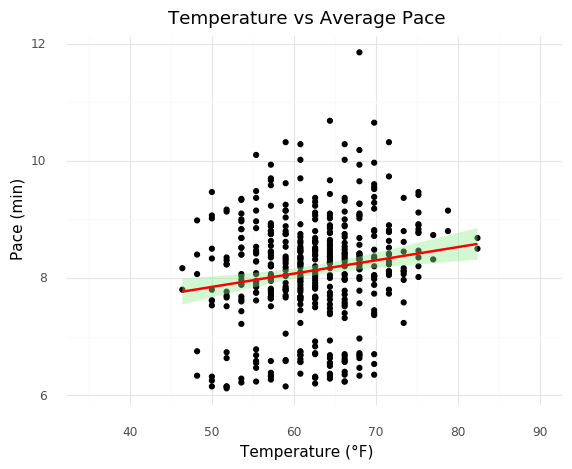

<ggplot: (8782352057097)>

In [13]:
#ggplot for temperature
(ggplot(df,aes(x="Min Temp",y="Avg Pace"))+
geom_point()+
geom_smooth(method="lm",color="red",fill="lightgreen")+
 ggtitle("Temperature vs Average Pace")+
 xlim(35,90)+
 xlab("Temperature (°F)")+
 ylab("Pace (min)")+
theme_minimal())

Does temperature have an effect on your avg pace?

As we can tell from the graph above, temprature has no real affect on the pace Dan will be running at. We can see as well that the the temperature stays within the range of around 50 degrees to slightly above 80. The is due to the workouts for the most part taking place within the same area and therefore we do not know how more extreme temperatures would affect average pace. Nonetheless given normal temperatures we can conclude that there is no correlation between these variables.  

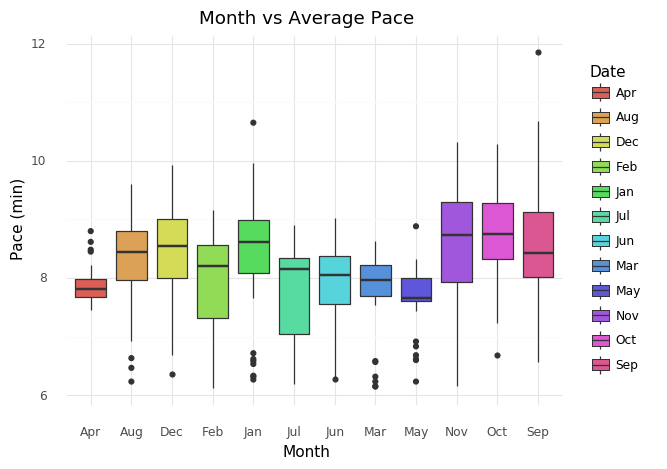

<ggplot: (8782352004601)>

In [14]:
#ggplot for temperature
(ggplot(df,aes(x="Date",y="Avg Pace",fill="Date"))+
geom_boxplot()+
 ggtitle("Month vs Average Pace")+
 theme(axis_title_x=element_blank(),
        axis_text_x=element_blank())+
 xlab("Month")+
 ylab("Pace (min)")+
theme_minimal())

Does the month have an effect on avg pace?
When we look at the graph above we can see a majority of our observations lie within a 7 to 10 minute mile pace. However we can also see that during the fall months of September, October and November the distribution of the observations is a lot wider than the other months as well has having a higher average pace. On the flip side, the spring months, March, April and May have a much more compact distibution and appear to be the fastest average pace. Whate we can gather from this is that seasons do have an effect on the pace Dan will be running at.

In [15]:
#calculating mse
db_pred = LR_model.predict(Xz_test)
mean_squared_error(y_test,db_pred)

0.04036440685540062

In [16]:
#R2 score
r2_score(y_test,db_pred)

0.9586767621592688

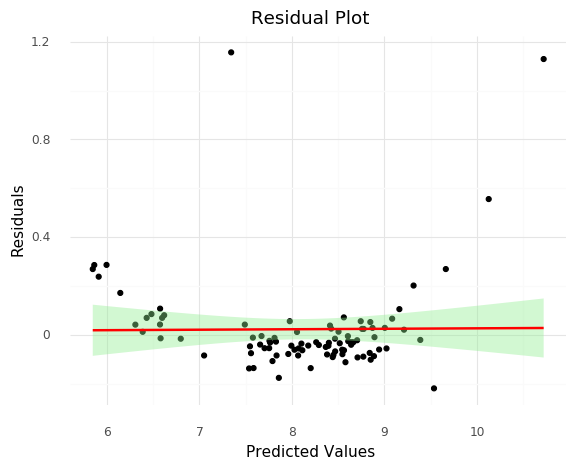

<ggplot: (8782352030133)>

In [17]:
#residual plot
true_vs_pred = pd.DataFrame({"predict": db_pred,"trueV": y_test})
true_vs_pred["residual"] = true_vs_pred["trueV"] - true_vs_pred["predict"]
(ggplot(true_vs_pred, aes (x = "predict", y = "residual"))+ 
 geom_point()+
 theme_minimal()+
 ggtitle("Residual Plot")+
 xlab("Predicted Values")+
 ylab("Residuals")+
geom_smooth(method="lm",color="red",fill="lightgreen"))

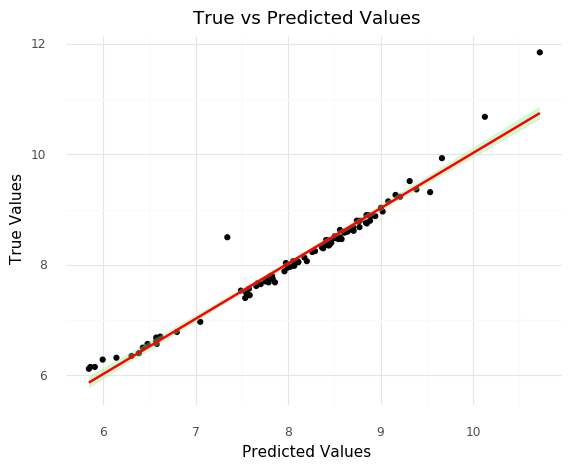

<ggplot: (8782351865561)>

In [18]:
#true vs pred plot
(ggplot(true_vs_pred, aes (x = "predict", y = "trueV"))+ 
 geom_point()+
 theme_minimal()+
 ggtitle("True vs Predicted Values")+
 xlab("Predicted Values")+
 ylab("True Values")+
geom_smooth(method="lm",color="red",fill="lightgreen"))

Model Performance:


In [19]:
#linear model two
#train test split 
predictors2 = ['Distance', 'Avg Pace', 'Time', 'Avg HR', 'Max HR', 'Aerobic TE', 'Avg Run Cadence', 'Max Run Cadence', 'Best Pace', 'Elev Gain', 'Elev Loss', 'Avg Stride Length', 'Min Temp']
np.random.seed(8675309)
X2_train, X2_test, y2_train, y2_test = train_test_split(df[predictors2], df["Calories Per Minute"], test_size=0.2)

In [20]:
#z-score our predictors
zScore = StandardScaler()
zScore.fit(X2_train)
Xz2_train = zScore.transform(X2_train)
Xz2_test= zScore.transform(X2_test)

#create linear regression model and fit
LR2_model= LinearRegression()
LR2_model.fit(Xz2_train,y2_train)

LinearRegression()

In [21]:
#creating coefficients dataframe
coefficients = pd.DataFrame({"Coef":LR2_model.coef_,
              "Name": predictors2})
coefficients = coefficients.append({"Coef": LR2_model.intercept_,
                    "Name": "intercept"}, ignore_index = True)
coefficients

,Coef,Name
0,-0.310796,Distance
1,-0.886842,Avg Pace
2,-0.253916,Time
3,0.991433,Avg HR
4,-0.098715,Max HR
5,-0.077768,Aerobic TE
6,-0.188623,Avg Run Cadence
7,0.005670,Max Run Cadence
8,0.057024,Best Pace
9,-0.187972,Elev Gain


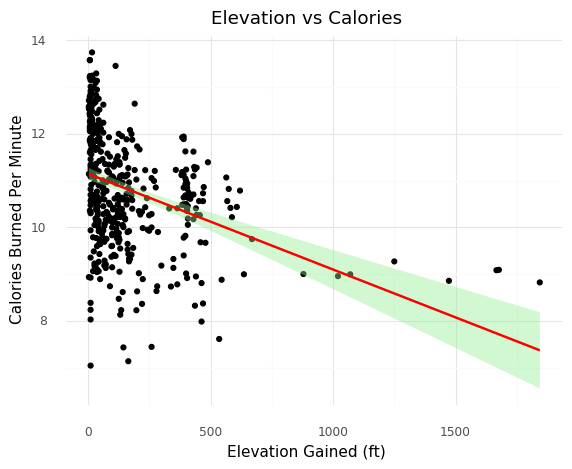

<ggplot: (8782351894993)>

In [22]:
#ggplot for temperature
(ggplot(df,aes(x="Elev Gain",y="Calories Per Minute"))+
geom_point()+
geom_smooth(method="lm",color="red",fill="lightgreen")+
 ggtitle("Elevation vs Calories")+
 xlab("Elevation Gained (ft)")+
 ylab("Calories Burned Per Minute")+
theme_minimal())

Does elevation gain have an effect on calories burned per minute?
We can see on the graph above that when Dan has more elevation gain in his runs that he tends to burn less calories per minute. At first when looking at this I thought it didn't make sense as I expected the opposite to occur. However once I thought about it, I realized what was occuring. Climbing hills is something that is very tiring and typically leads to you running a shorter distance than you would on flat ground. Essentially when hills are incorporated into a run, that run will not be as long, thereby the less total calories you are burning. This shorter workout paired with the less total calories being burned will lead to a lower amount of calories burned per minute.

In [23]:
#calculating mse
db2_pred = LR2_model.predict(Xz2_test)
mean_squared_error(y2_test,db2_pred)

0.1915266330465617

In [24]:
#R2 score
r2_score(y2_test,db2_pred)

0.8813122190498904

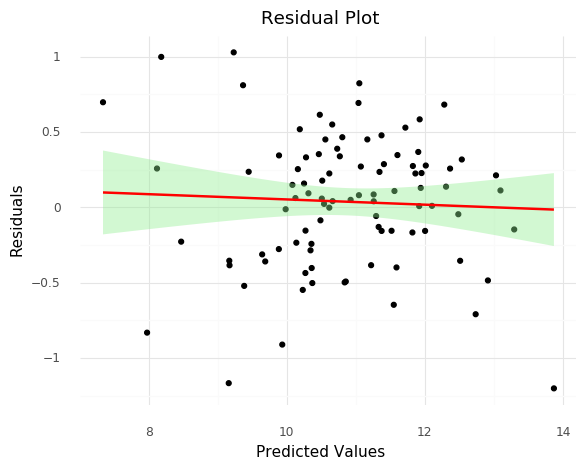

<ggplot: (8782351863237)>

In [25]:
#residual plot
true_vs_pred2 = pd.DataFrame({"predict": db2_pred,"trueV": y2_test})
true_vs_pred2["residual"] = true_vs_pred2["trueV"] - true_vs_pred2["predict"]
(ggplot(true_vs_pred2, aes (x = "predict", y = "residual"))+ 
 geom_point()+
 theme_minimal()+
 ggtitle("Residual Plot")+
 xlab("Predicted Values")+
 ylab("Residuals")+
geom_smooth(method="lm",color="red",fill="lightgreen"))

Model Performance:

For the second model, similar to the first it performed very well. Our MSE was very low with a value at 0.191 along with an r2 value of 0.88. The main difference between the two models apart from what they are predicting is that I chose to omit calories from this model as I felt it would lead a problem of over predicting as calories per minute and calories are linearly related. We can also take a look at the residual plot and we see that the points are randomly distributed as well as a very stable line, which is exactly what we are looking for.

### Does average stride length have an effect on calories burned?

In [26]:

#linear model 4
predictors3 = ['Distance', 'Avg Pace', 'Time', 'Max HR', 'Aerobic TE', 'Avg Run Cadence', 'Max Run Cadence', 'Best Pace', 'Elev Gain', 'Elev Loss', 'Avg Stride Length', 'Min Temp']
np.random.seed(8675309)
X3_train, X3_test, y3_train, y3_test = train_test_split(df[predictors3], df["Calories"], test_size=0.2)

#z-score our predictors
zScore = StandardScaler()
zScore.fit(X3_train)
Xz3_train = zScore.transform(X3_train)
Xz3_test= zScore.transform(X3_test)

#create linear regression model and fit
LR3_model= LinearRegression()
LR3_model.fit(Xz3_train, y3_train)

#creating coefficients dataframe
coefficients = pd.DataFrame({"Coef":LR3_model.coef_,
              "Name": predictors3})
coefficients = coefficients.append({"Coef": LR3_model.intercept_,
                    "Name": "intercept"}, ignore_index = True)
coefficients

,Coef,Name
0,230.834946,Distance
1,-55.922296,Avg Pace
2,66.970597,Time
3,-0.051153,Max HR
4,42.043794,Aerobic TE
5,-13.043634,Avg Run Cadence
6,2.851547,Max Run Cadence
7,1.293235,Best Pace
8,55.032224,Elev Gain
9,-36.199010,Elev Loss


In [27]:
df['Avg Stride Length'].corr(df['Calories'])

0.04770052320865322

In the linear regression performed above we saw that the coefficient for average stride length was -64.6. This means that with every increase in the standard unit of stride length, the calories burned decreases by around 65 standard units. However, the correlation coefficient was nearly zero so this does not hold much significance.

In [28]:
#MSE
db3_pred = LR3_model.predict(Xz3_test)
mean_squared_error(y3_test,db3_pred)

1925.4613425146306

In [29]:
#R2
r2_score(y3_test,db3_pred)

0.9842615096852873

I ended up doing a single train test split because the R^2 did very well and there shouldn't be too much fluctuation in respect to how much variability the model captured. I also regularized my predictors because I used more than one and wanted them to all be on the same scale.

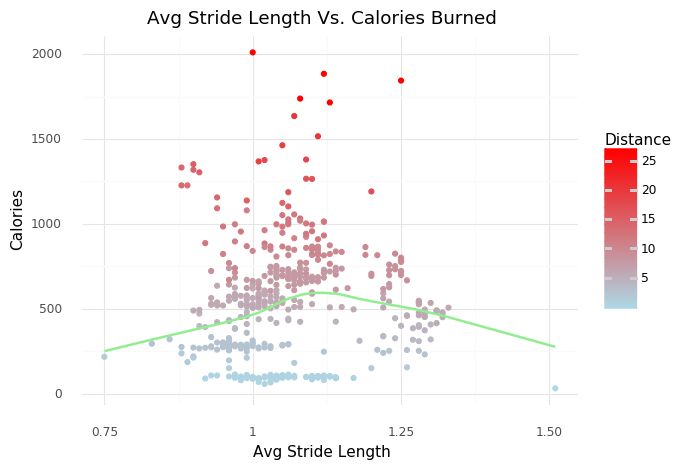

<ggplot: (8782351895541)>

In [30]:
(ggplot(df, aes(x = "Avg Stride Length", y = "Calories", color = "Distance")) + geom_point() + geom_smooth(color = "lightgreen") + 
 ggtitle("Avg Stride Length Vs. Calories Burned") + theme_minimal() + 
 scale_color_gradient(low = "lightblue", high = "red"))

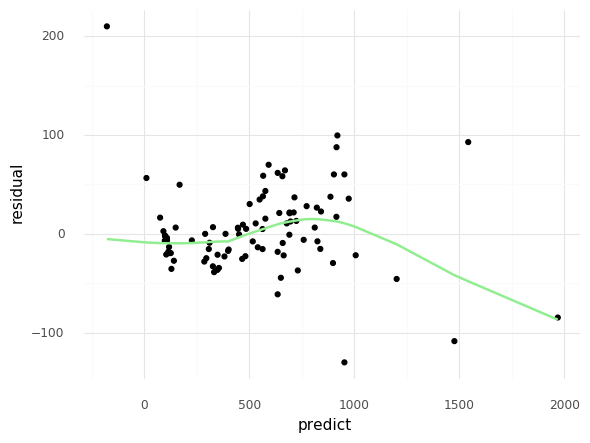

<ggplot: (8782350195465)>

In [31]:
#residual plot
true_vs_pred3 = pd.DataFrame({"predict": db3_pred,"trueV": y3_test})
true_vs_pred3["residual"] = true_vs_pred3["trueV"] - true_vs_pred3["predict"]
(ggplot(true_vs_pred3, aes (x = "predict", y = "residual")) + geom_point() +
geom_smooth(color = "lightgreen") + theme_minimal())

### Does average stride length have an effect on the average/max heart rate?

In [32]:
df['Avg Stride Length'].corr(df['Max HR'])

0.4968837744606276

In [33]:
df['Avg Stride Length'].corr(df['Avg HR'])

0.6580419090283486

In [34]:
#linear model 4
predictors4 = ['Distance', 'Avg Pace', 'Time', 'Max HR', 'Aerobic TE', 'Avg Run Cadence', 'Max Run Cadence', 'Best Pace', 'Elev Gain', 'Elev Loss', 'Avg Stride Length', 'Min Temp']
np.random.seed(8675309)
X4_train, X4_test, y4_train, y4_test = train_test_split(df[predictors4], df["Avg HR"], test_size=0.2)

#z-score our predictors
zScore = StandardScaler()
zScore.fit(X4_train)
Xz4_train = zScore.transform(X4_train)
Xz4_test= zScore.transform(X4_test)

#create linear regression model and fit
LR4_model= LinearRegression()
LR4_model.fit(Xz4_train, y4_train)

#creating coefficients dataframe
coefficients = pd.DataFrame({"Coef":LR4_model.coef_,
              "Name": predictors4})
coefficients = coefficients.append({"Coef": LR4_model.intercept_,
                    "Name": "intercept"}, ignore_index = True)
coefficients

,Coef,Name
0,-0.317499,Distance
1,-2.597282,Avg Pace
2,-2.129900,Time
3,3.346937,Max HR
4,2.285628,Aerobic TE
5,-1.084774,Avg Run Cadence
6,-0.398107,Max Run Cadence
7,0.535012,Best Pace
8,-2.423063,Elev Gain
9,2.578520,Elev Loss


In the linear regression performed above we saw that the coefficient for average stride length was 0.99. This means that with every increase in the standard unit of stride length, the average heart rate increases by around 1 standard units. This is significant as the two have an R value of 0.65. Average stride length seems to have an effect on average heart rate.

I used multiple predictors in this regression although I did not plan on it initially. I also standardized the predictors because I used multiple and wanted them to be on the same scale. I did a single train test split because K fold cross validation seemed excessive on a dataset with 463 observations.

In [35]:
#MSE
db4_pred = LR4_model.predict(Xz4_test)
mean_squared_error(y4_test,db4_pred)

22.54654542277583

In [36]:
r2_score(y4_test,db4_pred)

0.6387564070690974

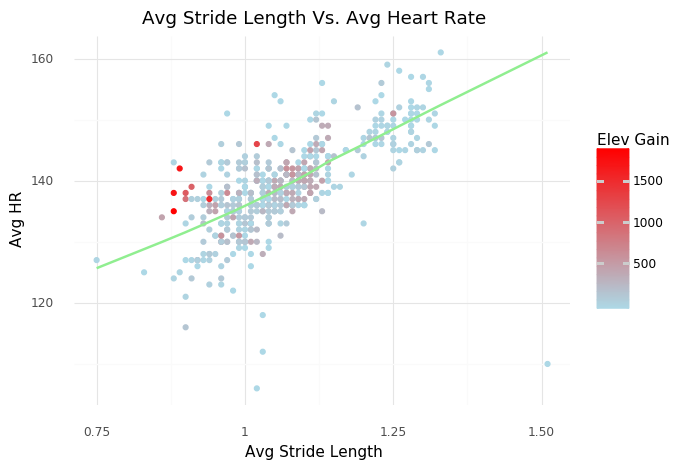

<ggplot: (8782351829725)>

In [37]:
(ggplot(df, aes(x = "Avg Stride Length", y = "Avg HR", color = "Elev Gain")) + geom_point() + geom_smooth(color = "lightgreen") + 
 ggtitle("Avg Stride Length Vs. Avg Heart Rate") + theme_minimal() + 
 scale_color_gradient(low = "lightblue",high = "red"))

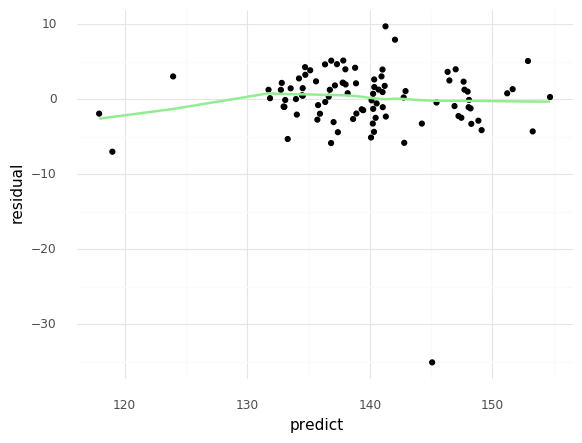

<ggplot: (8782351813137)>

In [38]:
#residual plot
true_vs_pred4 = pd.DataFrame({"predict": db4_pred,"trueV": y4_test})
true_vs_pred4["residual"] = true_vs_pred4["trueV"] - true_vs_pred4["predict"]
(ggplot(true_vs_pred4, aes (x = "predict", y = "residual")) + geom_point() +
geom_smooth(color = "lightgreen") + theme_minimal())

### Which variable in the running dataset has the largest impact on calories burned?

In [39]:
feat = predictors3
X5 = df[feat]
y5 = df["Calories"]

X5_train, X5_test, y5_train, y5_test = train_test_split(X5,y5, test_size = 0.25)

z = StandardScaler()

X5_train[feat] = z.fit_transform(X5_train[feat])
X5_test[feat] = z.transform(X5_test[feat])

In [40]:
from sklearn.linear_model import LassoCV

In [41]:
lsr = Lasso()

lsr.fit(X5_train,y5_train)

lsr_tune = LassoCV(cv = 5).fit(X5_train, y5_train)

print("TRAIN: ", mean_absolute_error(y5_train, lsr.predict(X5_train)))
print("TEST : ", mean_absolute_error(y5_test, lsr.predict(X5_test)))

print("\nwe chose " + str(lsr_tune.alpha_) + " as our alpha.")

TRAIN:  26.157270219709506
TEST :  26.686234036893726

we chose 1.846816348639107 as our alpha.


In [42]:
coefficients = pd.DataFrame({"Coef":lsr.coef_,
              "Name": predictors3})
coefficients = coefficients.append({"Coef": lsr.intercept_,
                    "Name": "intercept"}, ignore_index = True)
coefficients

,Coef,Name
0,255.934480,Distance
1,0.000000,Avg Pace
2,53.841739,Time
3,-0.000000,Max HR
4,38.497287,Aerobic TE
5,-5.639438,Avg Run Cadence
6,2.789533,Max Run Cadence
7,-0.000000,Best Pace
8,19.482885,Elev Gain
9,0.000000,Elev Loss


In [43]:
df['Distance'].corr(df['Calories'])

0.9883467941572286

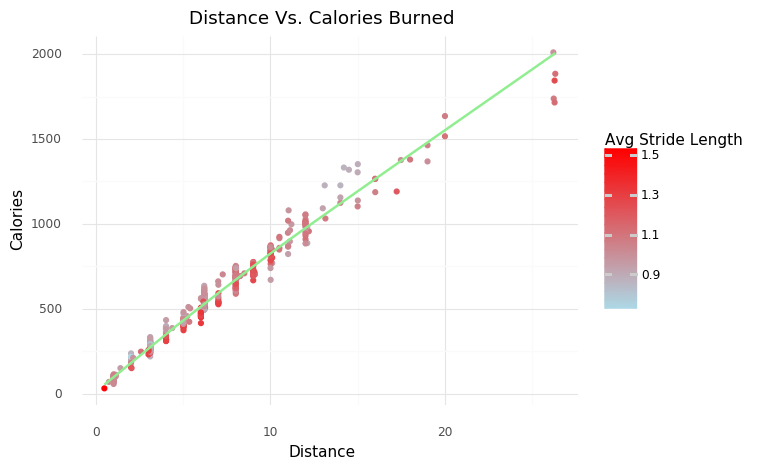

<ggplot: (8782352091821)>

In [44]:
(ggplot(df, aes(x = "Distance", y = "Calories", color = "Avg Stride Length")) + geom_point() + geom_smooth(color = "lightgreen") + 
 ggtitle("Distance Vs. Calories Burned") + theme_minimal() + 
 scale_color_gradient(low = "lightblue",high = "red"))

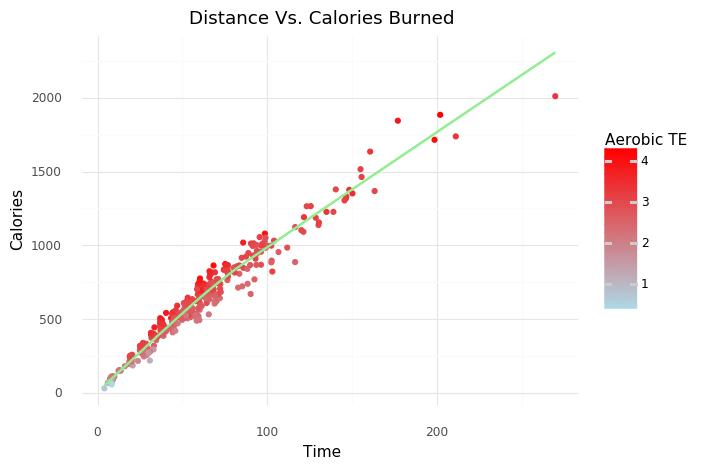

<ggplot: (8782352068061)>

In [45]:
(ggplot(df, aes(x = "Time", y = "Calories", color = "Aerobic TE")) + geom_point() + geom_smooth(color = "lightgreen") + 
 ggtitle("Distance Vs. Calories Burned") + theme_minimal() + 
 scale_color_gradient(low = "lightblue",high = "red"))

The variable that has the largest effect on calories burned is distance ran. This makes complete sense as the more you run the more calories you will burn. I made two scatter plots instead of looking at the residual plot for the lasso regression.

# Next Questions

In this part of the project, we will be analyzing new data sets from Garmin watches. I have had the watch since July and have gone on about 35 runs; therefore, there are not enought data points to analyze only my running. However, I use the watch to track all of my other workouts. The first dataset tracks all of my activities statistics. For the next data set, we will be analyzing many health statistics. Since I wear my watch almost 24/7 for the last 6 months, it has tracked many various health statistics.

# Activities Dataset
The activities dataset consists of statistics for each activitiy/exercise/workout that I have recorded. These include but are not limited to running, strength training, cycling, hiking, and cardio. I did not exercise every single day so the number of datapoints is not equal to the number of days that I have had my watch. Each specific type of activity can record statstics that don't apply to certain other activities - such as measuring distance when I am doing strength training. The full list of statistics that can be measured for any of the activities are here <sup>1</sup>. I will use the variables that apply to every activity: 

- `Activity Type`: What kind of activity/exercise it was
- `Date`:  Year month and Day of the activity
- `Time`: Duration of the activity
- `Calories`: Calories burned
- `Avg HR`: Average heart rate
- `Max HR`: Max heart rate

<sup>1</sup>('Activity Type', 'Date', 'Favorite', 'Title', 'Distance', 'Calories',
       'Time', 'Avg HR', 'Max HR', 'Aerobic TE', 'Avg Run Cadence',
       'Max Run Cadence', 'Avg Speed', 'Max Speed', 'Elev Gain', 'Elev Loss',
       'Avg Stride Length', 'Avg Vertical Ratio', 'Avg Vertical Oscillation',
       'Training Stress Score®', 'Grit', 'Flow', 'Total Reps', 'Total Sets',
       'Climb Time', 'Bottom Time', 'Min Temp', 'Surface Interval',
       'Decompression', 'Best Lap Time', 'Number of Laps', 'Max Temp',
       'Avg Resp', 'Min Resp', 'Max Resp')

In [46]:
activities = pd.read_csv("michael_new_activities.csv")
activities.head()

,Activity Type,Date,Favorite,Title,Distance,Calories,Time,Avg HR,Max HR,Aerobic TE,...,Best Lap Time,Number of Laps,Max Temp,Avg Resp,Min Resp,Max Resp,Stress Change,Stress Start,Stress End,Avg Stress
0,Cycling,2020-12-06,False,San Jose Cycling,25.35,890,1:49:24,123,166,2.8,...,03:15.0,6,0,16,16,16,--,--,--,--
1,Cycling,2020-12-05,False,San Jose Cycling,33.46,"1,303",2:00:28,138,178,3.4,...,12:30.1,7,0,17,17,17,--,--,--,--
2,Strength Training,2020-12-04,False,Strength,0.00,252,0:32:57,113,139,1.2,...,32:57.3,1,0,18,18,18,--,--,--,--
3,Cycling,2020-12-04,False,San Jose Cycling,11.80,639,0:51:33,140,178,3.1,...,07:35.9,3,0,16,16,16,--,--,--,--
4,Cycling,2020-12-03,False,San Jose Cycling,20.51,906,1:17:08,140,179,3.1,...,02:08.1,5,0,16,16,16,--,--,--,--


Number of activities: 191


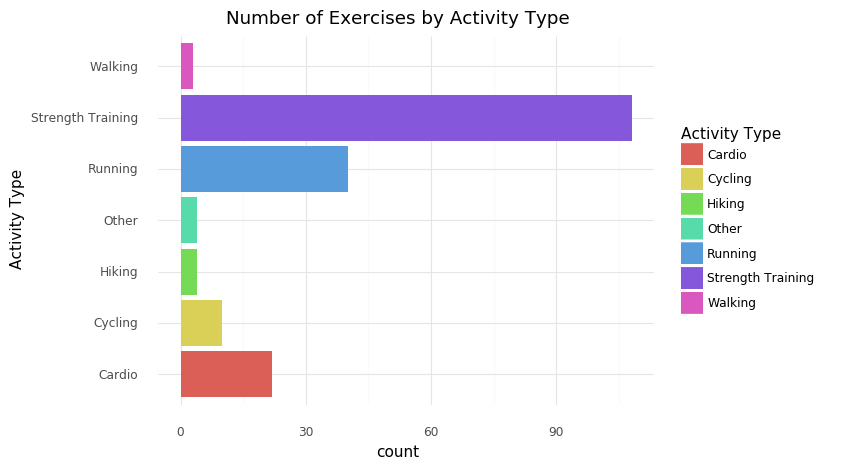

<ggplot: (8782352046681)>

In [47]:
# total number of workouts over 152 days
print("Number of activities:",len(activities))
# The distribution of the types of my workouts
(ggplot(activities, aes(x = "Activity Type", fill = "Activity Type")) 
 + geom_bar()
 + coord_flip()
 + theme_minimal()
 + labs(title='Number of Exercises by Activity Type'))

Above is the distribution of my exercises. I have a total of 191 different activities over the course of 152 days because I worked out multiple times in a day numerous times. However, there are still many days in which I did not work out.

# Health Statistics Dataset
The health stats dataset consists of a datapoint for every day since I started wearing the watch. The variables for each datapoint are:

- `Date`: Day and month
- `Day`: Day of the week
- `Stress Level`: Overall stress level for the day using a metric called heart rate variability(HRV) <sup>2</sup>
- `Sleep Hours`: Hours of sleep
- `Resting Heart Rate`: Resting heart rate <sup>3</sup>
- `Max Heart Rate`: Highest heart rate for the day
- `Active Calories`: Calories Burned in Motion <sup>4</sup>
- `Total Steps`: Number of steps taken

<sup>2</sup> When using the stress level feature, the device uses heart rate data to determine the interval between each heart beat. The variable length of time in between each heart beat is regulated by the body's autonomic nervous system. The less variability between beats equals higher stress levels, whereas the increase in variability indicates less stress. [Stress level feature](https://support.garmin.com/en-US/?faq=WT9BmhjacO4ZpxbCc0EKn9) [HRV](https://support.garmin.com/en-US/?faq=04pnPSBTYSAYL9FylZoUl5)

<sup>3</sup> Resting heart rate can be a key indicator of your heart's health. The Garmin device analyzes your lowest observed heart rate for a given day to determine your ersting heart rate. The main things that can affect heart rate are Exercise, Stress, Caffeine, Medication, Illness

<sup>4</sup> Active calories are the calories that you burn while moving throguhout the day.

In [48]:
health = pd.read_csv("michael_data.csv")
health.head()

,Date,Day,Stress Level,Sleep Hours,Resting Heart Rate,Max Heart Rate,Active Calories,Total Steps
0,8-Jul,Wed,20,8.7,42,158,1753,21366
1,9-Jul,Thu,31,8.5,46,182,1098,15775
2,10-Jul,Fri,32,7.6,49,165,1026,12190
3,11-Jul,Sat,32,6.1,46,143,993,20126
4,12-Jul,Sun,32,4.1,47,129,1054,20092


# Questions
Using these two datasets, I want to answer these questions:
### 1) Is stress level higher on days when you don’t exercise compared to if you do exercise?
### 2) What has the largest effect on stress, what is the best way to reduce stress, and how well can you predict stress from the other variables in the dataset?
### 3) How can the activities be clustered and what are the characteristics of each cluster?

* I changed question 3 from my analysis plan.

# Data pre-processing

## Clean up Activities

In [49]:
# Change the data from 'year-month-day' to 'day-month' in order to match the health dataset syntax 
def change_date(dates):
    month_dict = {"01": "Jan", "02": "Feb", "03": "Mar", "04": "Apr", "05": "May", "06": "Jun", "07": "Jul", "08": "Aug", "09": "Sep", "10": "Oct", "11": "Nov", "12": "Dec"}
    new_dates = []
    for row in dates:
        date_str = row.split()[0]
        month = month_dict[date_str.split("-")[1]]
        day = date_str.split("-")[2]
        if int(day) < 10:
            day = day[1]
        new_dates.append(day + "-" +  month)
    return new_dates

# convert the column of Time from "Hours:Minutes:Seconds" to "minutes" for each Time
def change_time(times): # List of times
    conversion = [60, 1, 1/60]
    new_times = []
    for row in times:
        time_list = row.split(":")
        minutes = 0.

        # multiple the respective indeces "Hours:Minutes:Seconds" by specific
        # amount to convert to minutes
        for i, conv in zip(time_list, conversion): 
            minutes += float(i) * conv

        new_times.append(round(minutes, 3))
    return new_times

# convert the column of calories for string values to int for each calorie
def calories_to_num(calories):
    return [int(calorie.replace(",", "")) for calorie in calories]

# keep only the columns that we need
def delete_columns(df):
    return df[["Activity Type", "Date", "Time", "Calories", "Avg HR", "Max HR"]]

In [50]:
activities = pd.read_csv("michael_new_activities.csv")
activities["Date"] = change_date(activities["Date"])
activities["Time"] = change_time(activities["Time"])
activities["Calories"] = calories_to_num(activities["Calories"])
activities = delete_columns(activities)
activities.head()

,Activity Type,Date,Time,Calories,Avg HR,Max HR
0,Cycling,6-Dec,109.400,890,123,166
1,Cycling,5-Dec,120.467,1303,138,178
2,Strength Training,4-Dec,32.950,252,113,139
3,Cycling,4-Dec,51.550,639,140,178
4,Cycling,3-Dec,77.133,906,140,179


## Fix the health dataset

In [51]:
# reverse the order of the dataset so that the most recent days 
# are at the top and the oldest days are at the bottome
def reverse_data(df):
    cols = df.columns.tolist()
    for i in cols:
        col = df[i].tolist()
        col.reverse()
        health[i] = col
    return df

# add a column for the number of days since wearing the watch
def append_days_num(df):
    days = [i for i in range(len(df),0,-1)]
    df["Day Num"] = days
    return df

# add a column to differentiate if the day was a week day or weekend
def append_weekends(df): 
    weekend = ["Fri", "Sat", "Sun" ]
    weekendData = ["Week Day"] * len(df)
    for i in range(len(df)):
        if (health["Day"][i] in weekend):
            weekendData[i] = "Weekend"
    df["Days of the Week"] = weekendData
    return df

In [52]:
health = pd.read_csv("michael_data.csv")
health = reverse_data(health)
health = append_days_num(health)
health = append_weekends(health)
health.head()

,Date,Day,Stress Level,Sleep Hours,Resting Heart Rate,Max Heart Rate,Active Calories,Total Steps,Day Num,Days of the Week
0,6-Dec,Sun,22,8.1,43,159,1062,8070,152,Weekend
1,5-Dec,Sat,29,8.5,45,169,1703,9244,151,Weekend
2,4-Dec,Fri,21,8.2,44,165,997,7791,150,Weekend
3,3-Dec,Thu,17,7.9,43,165,932,4402,149,Week Day
4,2-Dec,Wed,27,6.7,45,159,760,6286,148,Week Day


## Add Exercise Info Into Health Dataset
Now in order to answer the questions and compare my health statistics on days that I do exercise vs don't, I will need to add a column into the health dataset telling me if I exercised that day or not

In [53]:
# iterage through the days and look into the activities dataset to see if I exercised. I will add two columns
# The first will be a binary numerical column so that I can use this for Logistic Regression
# the second column is a binary string column used for graphs
def exercise_per_day(df_health, df_activities):
    date_health = df_health["Date"].tolist()
    date_exercise = df_activities["Date"].tolist()
    df_combined = df_health
    exercise = [0] * len(date_health)
    exercise_str = ["No Exercise"] * len(date_health)

    for i in range(len(date_health)): #len(date_health)):
        if date_health[i] in date_exercise:
            exercise[i] = 1
            exercise_str[i] = "Yes Exercise"
    df_combined["Exercise"] = exercise
    df_combined["Exercise_word"] = exercise_str
    return df_combined

## Clean Up Combined Dataset
I will be removing days where I did not wear the watch while sleeping because those days will give inaccurate health stats. Also I will be removing the days were my `Stress Level` was below 14 because on those days, I did not wear my watch for several hours during the day, and that level is very low and not conclusive. Overall, both of these changes take out the days where I did not wear my watch the full day.

In [54]:
df_combined = exercise_per_day(health, activities)
print("Number of days in dataset before Clean:", len(df_combined))
df_combined = df_combined.loc[df_combined["Sleep Hours"] != 0]
df_combined = df_combined.loc[df_combined["Stress Level"] > 14]
print("Number of days in dataset after Clean:", len(df_combined))
print()
print("Number of days I didn't workout:",df_combined["Exercise"].tolist().count(0))
print("Number of days I did workout:", df_combined["Exercise"].tolist().count(1))
df_combined.head()

Number of days in dataset before Clean: 152
Number of days in dataset after Clean: 123

Number of days I didn't workout: 29
Number of days I did workout: 94


,Date,Day,Stress Level,Sleep Hours,Resting Heart Rate,Max Heart Rate,Active Calories,Total Steps,Day Num,Days of the Week,Exercise,Exercise_word
0,6-Dec,Sun,22,8.1,43,159,1062,8070,152,Weekend,1,Yes Exercise
1,5-Dec,Sat,29,8.5,45,169,1703,9244,151,Weekend,1,Yes Exercise
2,4-Dec,Fri,21,8.2,44,165,997,7791,150,Weekend,1,Yes Exercise
3,3-Dec,Thu,17,7.9,43,165,932,4402,149,Week Day,1,Yes Exercise
4,2-Dec,Wed,27,6.7,45,159,760,6286,148,Week Day,1,Yes Exercise


As seen above, my new data set constists of 123 days, 29 of which I did not exercise and 94 of which that I did exercise. 

Now we have everything we need to answer the first question:


# Answering The Questions

## Question 1: Is stress level higher on days when you don’t exercise compared to if you do exercise?

For this, we will be answering the question if exercise really does reduce stress. 

Mean Stress Level if I exercised: 24.414893617021278
Mean Stress Level if I didn't exercise 32.241379310344826


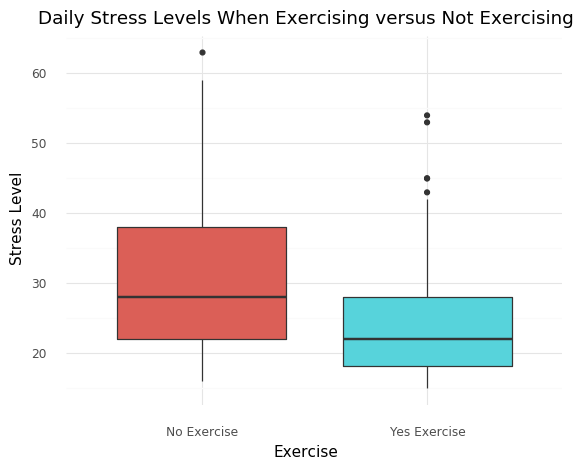

<ggplot: (8782358982581)>

In [55]:
print("Mean Stress Level if I exercised:",df_combined["Stress Level"].loc[df_combined["Exercise"] == 1].mean())
print("Mean Stress Level if I didn't exercise",df_combined["Stress Level"].loc[df_combined["Exercise"] == 0].mean())

(ggplot(df_combined, aes(x = "Exercise_word", y = "Stress Level", fill = "Exercise_word"))
 + geom_boxplot()
 + theme_minimal()
 + theme(legend_position = "none")
 + labs(x = "Exercise", title = "Daily Stress Levels When Exercising versus Not Exercising"))

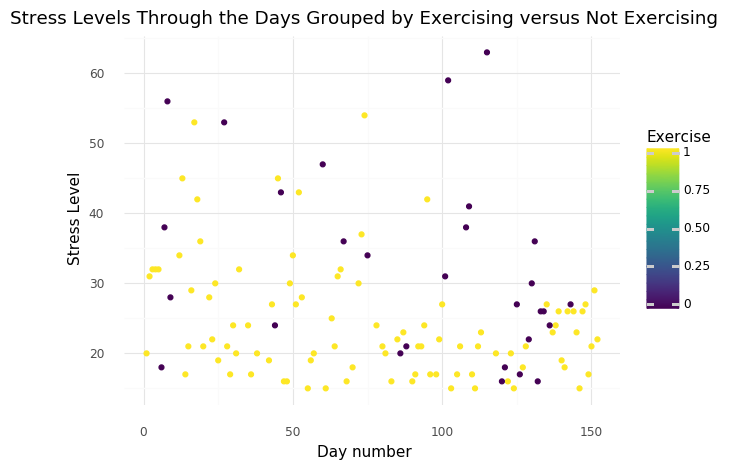

<ggplot: (8782351815721)>

In [73]:
(ggplot(df_combined, aes(x = "Day Num", y = "Stress Level", color = "Exercise"))
 + geom_point()
 + theme_minimal()
 + labs(x = "Day number", title = "Stress Levels Through the Days Grouped by Exercising versus Not Exercising"))

Day number 1 represents the first day I started wearing my watch. When I exercise, the points are yellow and are much lower on average than the purple points. My stress levels have been consolidating to be more consistent over the last several months.

## Question 1 Conclusion
My stress level for the days that I did exercise was 24.41, and my stress level for the days that I didn't exercise was 32.24. There is a staggering 24% decrease in my stress levels because of exercise. For reference, levels between 0-25 are considered to be a state a rest and relaxation. Levels between 26-50 are considered to be low stress. These values in my dataset are calculated by my average stress level throughout the day (24 hours). 
Therefore, it is clear that exercise does decrease stress and is a also a great way to reduce stress. I always hear people recommend to workout everyday in order to reduce stress and anxiety, but until now I never had evidence that exercise does actually reduce stress. So to me, these results are really fascinating and are a great motivation for me to keep exercising every day.

## Question 2: What has the largest effect on stress, what is the best way to reduce stress, and how well can you predict stress from the other variables in the dataset.

For this question, I will look at how sleep, resting heart rate, active calories, steps, and exercise effect Stess levels. Also, I will be making a linear regression model to see what predictor has the largest effect on stress level. I will be using a linear regression for this problem because the outcome variable is contiuous, and the input variables will help predict the stress level.

I will be z-scoring because standardizing our variables helps answer the question by putting each predictor variable on similar scales so that we easily compare their effects on stress level. I did not z-score the exercise variable because it is a binary variable, 1 for exercising and 0 for not exercising. It makes the coefficient easier to understand because it is either one or the other.

In [56]:
predictors = ['Sleep Hours', 'Resting Heart Rate', 'Max Heart Rate', 'Active Calories', 'Total Steps', 'Exercise']
variables_zscore = ['Sleep Hours', 'Resting Heart Rate', 'Max Heart Rate', 'Active Calories', 'Total Steps']
y = df_combined["Stress Level"]
z = StandardScaler()
model = LinearRegression()
df_combined[variables_zscore] = z.fit_transform(df_combined[variables_zscore])
model.fit(df_combined[predictors], y)
y_pred = model.predict(df_combined[predictors])
print("MSE:", mean_absolute_error(y, y_pred))
print("r2 score:", model.score(df_combined[predictors], y))
coef = pd.DataFrame({"Coef": model.coef_, "Names" : predictors})
coef = coef.append({"Coef" : model.intercept_, "Names" : "intercept"}, ignore_index = True)
coef

MSE: 4.1487778504587505
r2 score: 0.7419418115834637


,Coef,Names
0,-2.033672,Sleep Hours
1,6.335402,Resting Heart Rate
2,-1.553524,Max Heart Rate
3,4.657201,Active Calories
4,-1.001066,Total Steps
5,-5.807020,Exercise
6,30.698048,intercept


I created a linear regression model using 'Sleep Hours', 'Resting Heart Rate', 'Max Heart Rate', 'Active Calories', 'Total Steps', 'Exercise' as predictors to predict the stress level. Shown above we see that the mean error was about 4.14. So my model was on average 4.14 values off from the real stress level, which is pretty acurrate. Also, the r2 score was .74 which is a good score meaning that my model explains the variablity in the data well.

Above are also the coefficients for each variable. What these coefficients mean is that a unit increase in the respected variable, results in a X change in our stress level. Each variable except exercise is z-scored, so they are all on similar scales. We can see that if I exercise, it will reduce my stress by 5.8 levels. As sleep, max heart rate, and total steps increase, stress level decreases, so they have a negative relationship. As resting heart rate and active calories increase, stress increases, so they have a positive relationship. The variable with the largest affect on stress was Resting Heart Rate. A one unit change in the resting heart rate resulted in an increase of stress by 6.3 levels. This is very interesting because as my resting heart rate gets higher than usual, my stress level will also increase.

To see this relation ship between stress and resting heart rate, below is a scatter plot with resting heart rate versus stress level

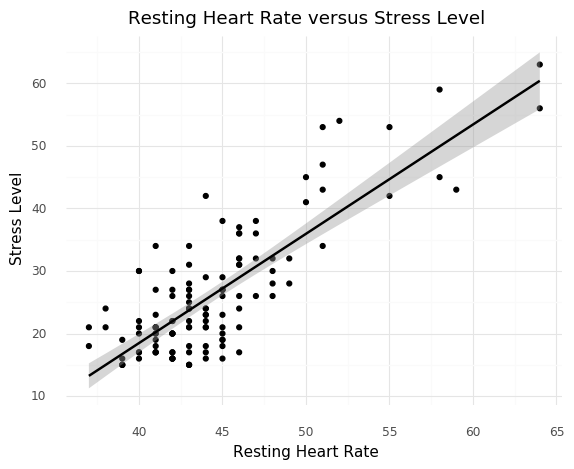

<ggplot: (8782358957773)>

In [57]:
df_combined = exercise_per_day(health, activities)
df_combined = df_combined.loc[df_combined["Sleep Hours"] != 0]
df_combined = df_combined.loc[df_combined["Stress Level"] > 14]
(ggplot(df_combined, aes(x = "Resting Heart Rate", y = "Stress Level")) 
 + geom_point()
 + theme_minimal()
 + stat_smooth(method = "lm")
 + labs(title = "Resting Heart Rate versus Stress Level"))

From the graph above, we can see that resting heart rate and stress level are positive linearly related. As resting heart rate goes up, stress level also goes up. 

Now below I will make a residual graph of the linear regression model:

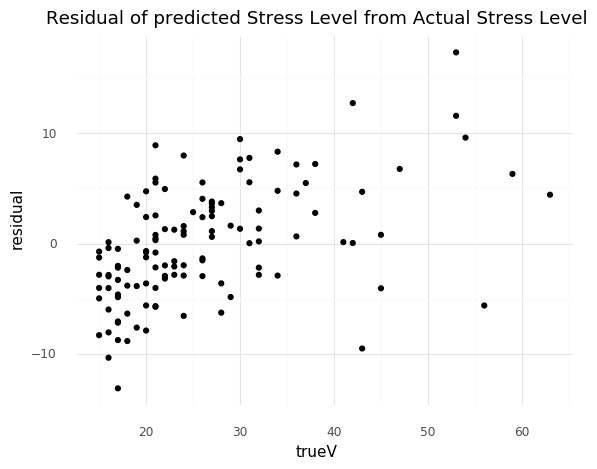

<ggplot: (8782351848753)>

In [58]:
true_vs_pred = pd.DataFrame({"predict": y_pred,"trueV": y})
true_vs_pred["residual"] = true_vs_pred["trueV"] - true_vs_pred["predict"]
(ggplot(true_vs_pred, aes(x = "trueV", y = "residual")) + 
 geom_point() + 
 theme_minimal() +
 ggtitle("Residual of predicted Stress Level from Actual Stress Level"))

From the graph above, we can see that the model over predicted for the low stress levels while gradually over predicting when the stress level gets higher. Although there is not that many datapoints, the residual does not look homoskedastic because the residuals get big at high and low stress levels.

## Question 2 Conclusion
You can accurately predict stress level from the other variables in the dataset. The linear regression model got an r2 score of .74 which is fairly high. Resting heart rate has the highest effect on stress level, as resting heart rate increases by 1 unit (1 standard deviation), stress level also increases by a large 6.33 levels. The best way to reduce stress is to sleep more, take more steps throughout the day, and also exercise. 

# Question 3: How can the activities be clustered and what are the characteristics of each cluster?
For this question, I will look at clustering my activities. Using features: "Time", "Calories", "Avg HR", "Max HR", I will group my data points. There were several datapoints where I forgot to end the activity on my watch, so I will remove these points. I created a dendrogram to visualize how many clusters are in the dataset

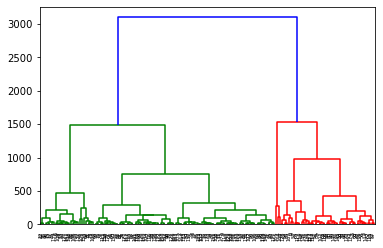

In [59]:
activities = activities.loc[activities["Time"] < 200]
features = ["Time", "Calories", "Avg HR", "Max HR"]
dendro = sch.dendrogram(sch.linkage(activities[features], method='ward'))

There are two groups in the dataset, so I will use agglomerative clustering with 2 clusters. I will use euclidean distance along with ward linkage. I am using ward linkage because it gives the best results.

In [60]:
hac = AgglomerativeClustering(n_clusters = 2, affinity = "euclidean", linkage = "ward")
hac.fit(activities[features])

AgglomerativeClustering()

In [61]:
membership = hac.labels_
print("The silhouette score:",silhouette_score(activities[features], membership))

The silhouette score: 0.5395668774105017


The model performed somewhat well, it did an ok job at keeping clusters cohesive and seperable. I used silhouette score to measure this because it measures how cohesive and seperable a models clusters are. The silhouette score ranges from -1 to 1, where 1 is the best score. I got a score of about .54. 

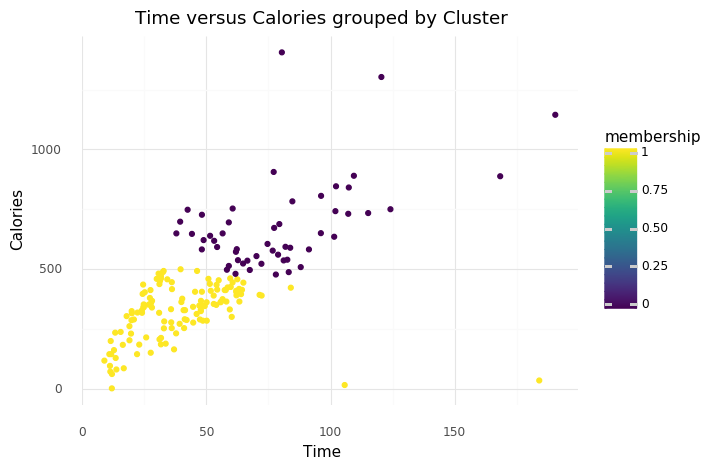

<ggplot: (8782359110305)>

In [62]:
(ggplot(activities, aes(x = "Time", y = "Calories", color = "membership")) 
 + geom_point()
 + theme_minimal()
 + labs(title = "Time versus Calories grouped by Cluster"))

The graph above shows that cluster 1 consists of the activities where I did not burn that many calories. Cluster 0 consists of the activities where I burned a significantly large number of calories. Cluster 0 represents hard workouts where I spent a long time exercising and burned lots of calories. These are workouts where I really pushed myself and worked hard.

## Question 3 Conclusion
The activities were grouped into two clusters. The first cluster represented activities where I did not burn that many calories. These are probably workouts where I did not have high intensity and did quickly. The second cluster represented activities where I burned lots of calories and spent a long time working out; these are workouts where I really pushed my self.

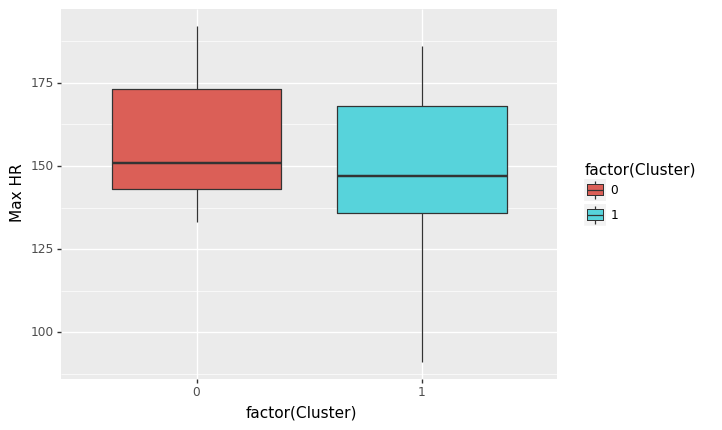

<ggplot: (8782359108289)>

In [63]:
activities["Cluster"] = membership
(ggplot(activities, aes( x = "factor(Cluster)", y = "Max HR")) + geom_boxplot(aes(fill = "factor(Cluster)")))